# Multi-label Computer Vison Classification

This notebook explores FastAI and PyTorch to model an image recognition application. The dataset provided [here](https://www.kaggle.com/agrigorev/clothing-dataset-full) contains 5000 high resolution images of clothes. The model is designed based on this dataset to distinguish among various types of clothing. Unlike the other datasets, this has 2 different variables identifying the piece of clothing - the first variable determines if the image contains a children's clothing and the second variable names the item. After the model has been designed, iPython widgets are used to test the model which can then be deployed onto a server for full functioning end-to-end application.

In [1]:
# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.vision.all import *
from fastai.vision.widgets import *

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

The dataset provided has 2 subsets - one with thee original images and 20 classes, and the other with resized images and only top 10 classes. This notebook uses the original dataset.

## Data Cleaning

In [2]:
# Import the dataset 
labels = pd.read_csv('/kaggle/input/clothing-dataset-full/images.csv')

In [3]:
labels.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


The 'image' column contains the names of the images. This will be mapped to the folder they are stored at to access them while creating the model. The 'label' column identifies the piece of clothing whereas the 'kids' column identifies if the clothing is for children or not.

In [4]:
# Classes and their counts within the dataset
labels['label'].value_counts()

T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Not sure       228
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Other           67
Top             43
Blouse          23
Skip            12
Name: label, dtype: int64

Replace 'Not sure' with 'Not_sure'.

In [5]:
labels.loc[labels['label']=='Not sure','label'] = 'Not_sure'

Add suffix '.jpg' to all image files in the dataframe to open them within the model.

In [6]:
labels['image'] = labels['image'] + '.jpg'

Merge the two lables 'label' and 'kids' into one column using space as a delimiter.

In [7]:
labels['label_cat'] = labels['label'] + ' ' + labels['kids'].astype(str)

Keep only the images and their labels for the model to process.

In [8]:
label_df = labels[['image', 'label_cat']]

## Preprocessing

Now that the dataframe is cleaned and ready to develop the model, it has to be transformed in a way that can be used to create the model. We are using FastAIs Convolusional Neural Network classifier 'resnet18'. This CNN has 18 layers with pretrained weights. 

The input to create the learner is a dataloader and the model 'resnet18'. The learner uses 'accuracy_multi', which calculates the accuracy for a multi-category dataset using a specified threshold. The threshold by default is 0.5, but for this model, we can start at 0.2 and then test the outcome of other threshold values. 

To create the dataloader, we need to have a DataBlock that will identify the dependent (labels) and the independent (images) variables using the MultiCategoryBlock and ImageBlock respectively. Using ImageBlock will help open the image and convert to a tensor, while MultiCategoryBlock will help with the multilabel classification.

Create functions that will be used to open the images and get the categories of the image for the DataBlock.

In [9]:
path = '/kaggle/input/clothing-dataset-full'
def get_x(r): return path+'/images_original/'+r['image'] # create path to open images in the original folder
def get_y(r): return r['label_cat'].split(' ') # split the labels using space as a delimitter

In [10]:
# Create DataBlock
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                  get_x = get_x, get_y = get_y,
                  item_tfms = RandomResizedCrop(128, min_scale=0.35))  # ensure every item is of the same size
dls = dblock.dataloaders(label_df) # collates items from dataset into minibatches

We can view the dataloader images and their subsequent labels.

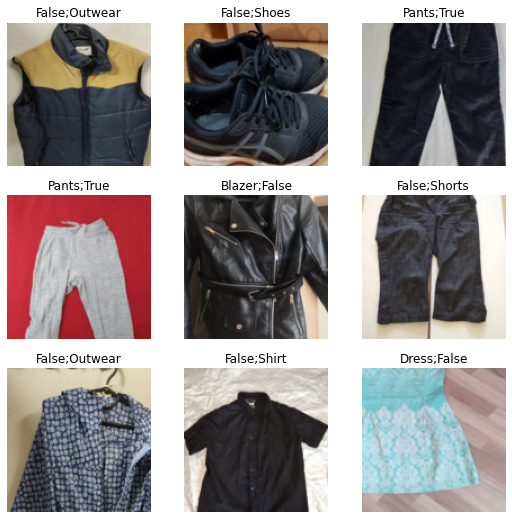

In [11]:
dls.show_batch(nrows=3, ncols=3)

## Create the Learner

Now that the DataLoader is ready, we can now create the learner with the threshold 0.2.

In [12]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(5, base_lr=3e-3)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.800899,0.344154,0.481187,10:41


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.328406,0.160712,0.907408,11:13
1,0.194522,0.111734,0.954040,11:17
2,0.135415,0.094324,0.962668,10:56
3,0.108078,0.089089,0.964983,10:58
4,0.096320,0.087574,0.964226,10:58


Using 5 epocs, we trained the last layer of the CNN with 18 layers and used the learning rate of 0.003. The 'fine_tune' function uses one epoch to train the final layer on the CNN and then unfreezes the entire model and trains all the 18 layers.  With 5 epochs, we have been able to gain a training accuracy of 96.48%. 

Now that the learner has been created, we can test different threshold values on the validation set to find the right value to predict the labels.

In [13]:
# Get Predictions and target variables
preds,targs = learn.get_preds()

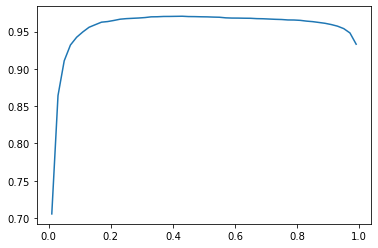

In [14]:
xs = torch.linspace(0.01,0.99,50)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs] # get_preds applies sigmoid activation function
plt.plot(xs,accs);

The predictictions are high at the threshold value of 0.1 and above. The smoothness of the curve until what seems to be 0.9 shows that we wont be overfitting by picking a random value. Thus maintaining the threshold at 0.2 should result in non-biased predictions.

The learner can exported to deploy it on a server for an application. Run this notebook on JupyterNotebook server to use the following command to download the model as a .pkl file to the home directory.

In [15]:
learn.export(Path("/kaggle/working/export.pkl"))

This model will be stored in the home directory. To import it into you new application use 'load_learner(export.pkl)'

## Test The Model

As mentioned above, the model is ready to be imported to a server for an end-to-end application. Although the model can be tested using iPython widgets. We can create a mini interface to upload images and classify them accordingly.

In [16]:
upload = widgets.FileUpload()
out_image = widgets.Output()
prediction = widgets.Label()
run = widgets.Button(description='Classify')

# btn_upload = widgets.FileUpload()
# out_pl = widgets.Output()
# lbl_pred = widgets.Label()
# btn_run = widgets.Button(description='Classify')

In [17]:
def on_click_classify(change):
    img = PILImage.create(upload.data[-1])
    out_image.clear_output()
    with out_image: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn.predict(img)
    pred0 = pred[0]
    pred1 = pred[1]
    if pred0=='False':
        prediction.value = f'This is a {pred1} for adults.'
    else:
        prediction.value = f'This is a {pred1} for kids.'

run.on_click(on_click_classify)

In [18]:
# Use Virtual Box to encapsulate the iPython widgets
VBox([widgets.Label('Upload a picture of a pice of clothing!'), 
      upload, run, out_image, prediction])

To make use of this application, upload this notebook and run it in its entirety to test it out. This is just one example amomg many to prove that the model works! A full-fleged application can be used idenitfy multiple kinds of clothing that can lead to further processes as required to fulfil the needs of the user.

Huge thanks to Alexey Grigorev for this dataset and to Jeremy Howard for the FastAI course.